In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Setup

In [ ]:
import os
import pickle
import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import statistics
import string
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


## Functioanlity for later Analysis

In [ ]:
def show_confusion_matrix(confusion_matrix, names = ['Non-Sci', 'Scientifc'], top_only = False):
  if top_only:
    confusion_df = pd.DataFrame(confusion_matrix[0,:].reshape(1,2), index=[names[0]],columns=names)
  else:
    confusion_df = pd.DataFrame(confusion_matrix, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cbar=False, square=True,fmt='.2f', cmap = 'cividis')
  plt.ylabel(r'Input Prediction',fontsize=14)
  plt.xlabel(r'Output Prediction',fontsize=14)
  plt.tick_params(labelsize=12)
  plt.show()


def num_transfered(df, classifier = 'roberta', display_cm = False, top_only = False):

  cache = df[[f'input_{classifier}_label', f'output_{classifier}_label']].sum(axis = 0)
  print(cache)

  if display_cm:
    cm = confusion_matrix(df[f'input_{classifier}_label'], df[f'output_{classifier}_label'], normalize='true')
    show_confusion_matrix(cm, top_only=top_only)
    #disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Sci', 'Sci'])
    #disp.plot(values_format= '.2g', cmap = 'cividis')
    #plt.show()

  if classifier == 'svm':
    ratio = cache[f'output_{classifier}_label']/cache[f'input_{classifier}_label'] 
    print(f'Ratio: {ratio:.2f}')

  print()


def analysis(df, classifier = 'roberta', display_cm = False, top_only = False):
  print(f'Using: {classifier}')
  print('All sentences: ')
  num_transfered(df=df, classifier=classifier, display_cm=display_cm, top_only= top_only)

  for key in set(df.source.to_list()):
    print(f'Considering only sentences from: {key}')
    df_subset = df[df.source == key]
    num_transfered(df=df_subset, classifier=classifier, display_cm=display_cm, top_only=top_only)

def prob_diff(df):

  diff = {}
  diff['all'] = df['output_roberta_prob']-df['input_roberta_prob']
  
  for key in set(df.source.to_list()):
    print(f'Considering only sentences from: {key}')
    df_subset = df[df.source == key]
    diff[key] = df_subset['output_roberta_prob']-df_subset['input_roberta_prob']
    
  fig, ax = plt.subplots(1,1)
  ax.hist([x for _,x in diff.items()], label =[key for key,_ in diff.items()], density = True, bins = 20)
  ax.legend()
  plt.show()

  for key, x in diff.items():
    print()
    print(f'{key}: mean:{np.mean(x):.2f}, (std: {np.std(x):.2f}) ')



# Loading Data

In [ ]:
data_path = '/models/model 2 - style transfer/evaluation/data/'

# Model1: T5 from Phase2
data_T5_p2 = pd.read_csv(data_path+'T5_phase2_combined_corrected.csv')

# Model2: T5 from Phase3
data_T5_p3 = pd.read_csv(data_path+'T5_phase3_combined_corrected.csv')

# Model3: GPT from Phase3
data_GPT2_p3 = pd.read_csv(data_path+'GPT2_phase3_combined_corrected.csv')

# Easier Access with dict
data ={'T5_p2': data_T5_p2, 'T5_p3': data_T5_p3, 'GPT2': data_GPT2_p3}

In [ ]:
data_T5_p2.head()

In [ ]:
data_T5_p3.head()

In [ ]:
data_GPT2_p3.head()

# Transfer Success by Model and CLF

## SVM

We evaluate the style transfer success by using confusion matrices. This way, one can see the transfer of labels between model input and output.

This done for each model:
  - first for all test sentences
  - then for test sentences according to each data source (medium, stduent reports, accepted papers)

Analysing: T5_p2
Using: svm
All sentences: 
input_svm_label     1167
output_svm_label    1336
dtype: int64


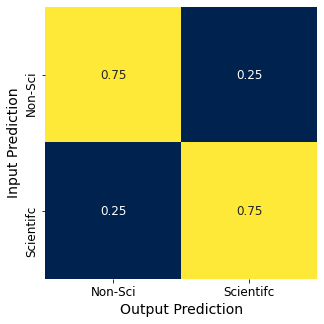

Ratio: 1.14

Considering only sentences from: cs_conf
input_svm_label     447
output_svm_label    495
dtype: int64


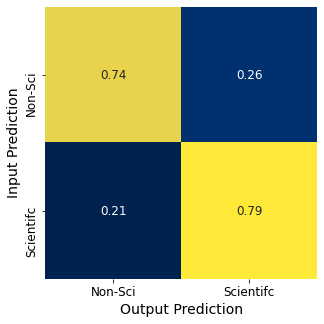

Ratio: 1.11

Considering only sentences from: student
input_svm_label     396
output_svm_label    467
dtype: int64


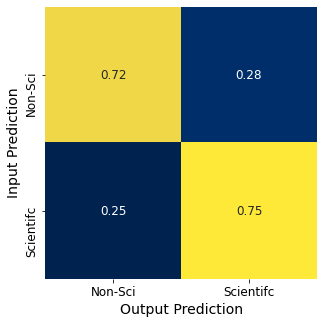

Ratio: 1.18

Considering only sentences from: medium
input_svm_label     324
output_svm_label    374
dtype: int64


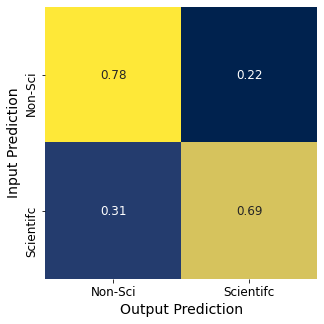

Ratio: 1.15


Analysing: T5_p3
Using: svm
All sentences: 
input_svm_label     1167
output_svm_label    1190
dtype: int64


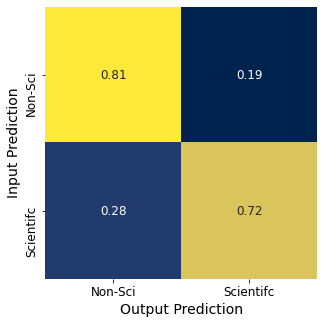

Ratio: 1.02

Considering only sentences from: cs_conf
input_svm_label     447
output_svm_label    428
dtype: int64


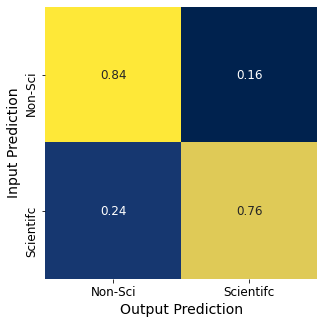

Ratio: 0.96

Considering only sentences from: student
input_svm_label     396
output_svm_label    401
dtype: int64


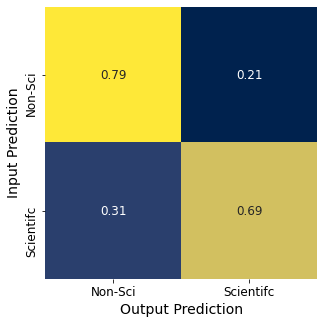

Ratio: 1.01

Considering only sentences from: medium
input_svm_label     324
output_svm_label    361
dtype: int64


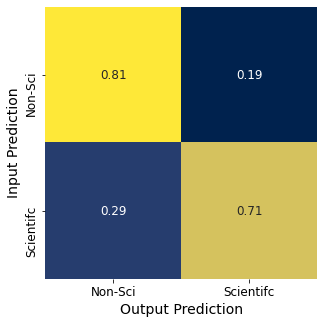

Ratio: 1.11


Analysing: GPT2
Using: svm
All sentences: 
input_svm_label     1167
output_svm_label    1096
dtype: int64


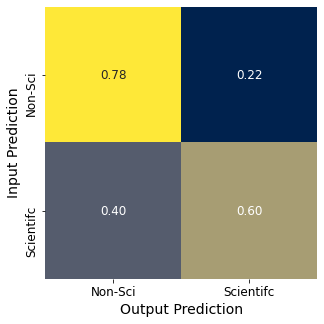

Ratio: 0.94

Considering only sentences from: cs_conf
input_svm_label     447
output_svm_label    451
dtype: int64


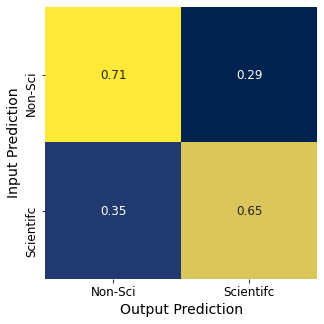

Ratio: 1.01

Considering only sentences from: student
input_svm_label     396
output_svm_label    364
dtype: int64


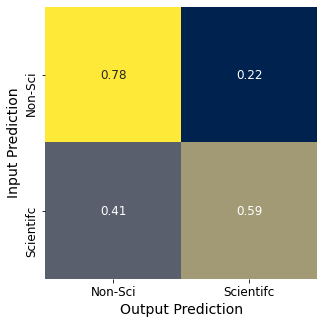

Ratio: 0.92

Considering only sentences from: medium
input_svm_label     324
output_svm_label    281
dtype: int64


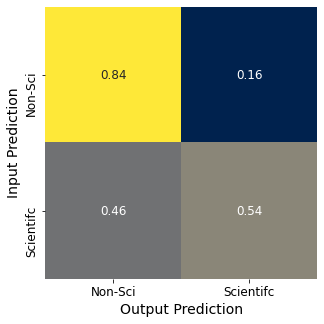

Ratio: 0.87




In [ ]:
for key, df in data.items():
  print(f'Analysing: {key}')
  analysis(df, classifier='svm', display_cm=True)
  print()

**Some imporved sentences according to SVM**

In [ ]:
cond = (data_T5_p2['output_svm_label']==1)*(data_T5_p2['input_svm_label']==0)
print(len(data_T5_p2[cond]))
data_T5_p2[cond].head()

463


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,Unnamed: 0,source,input,output,input_masked,output_masked,input_roberta_label,input_roberta_prob,input_svm_label,output_roberta_label,output_roberta_prob,output_svm_label,MoverScore,BLEU
5,5,cs_conf,"a targeted attack is the same as random removal, because the degree distribution is a delta function.","targetted attack and random removal, since the degree distribution is a delta function.","a targeted <unk> is the same as <unk> removal, because the degree <unk> is a delta <unk>.","targetted attack and <unk> removal, since the degree distribution is a delta <unk>.",0,0.378312,0,0,0.143292,1,0.668293,0.392892
6,6,cs_conf,"in the ideal data case, we can see that the sequential methods outperform all the other algorithms in terms of runtime.","in the ideal case, all other algorithms are slightly longer than the sequential method.","in the ideal <unk> <unk>, we can see that the sequential <unk> outperform all the other <unk> in <unk> of runtime.","in the ideal <unk>, all other <unk> are slightly longer than the sequential <unk>.",0,0.485732,0,1,0.944336,1,0.488020,0.146112
23,23,cs_conf,the proxies were installed just as they exist on the production memento machines.,the same replica was installed on each machine.,the proxies were installed just as they exist on the production memento <unk>.,the same replica was installed on each <unk>.,0,0.357642,0,0,0.481094,1,0.342163,0.139604
24,24,cs_conf,"before we proceed with the argument, some comments are in order.","before proceeding with the argument, a few remarks are a good idea.","before we proceed with the <unk>, some comments are in <unk>.","before proceeding with the argument, a few remarks are a good idea.",0,0.436172,0,0,0.003290,1,0.677993,0.197174
28,28,cs_conf,we will start with some rudimentary examples and gradually build up a toolkit for general networks.,we're going to start with basic examples and build gradually a comprehensive toolkit for general networks.,we will start with some rudimentary <unk> and gradually build up a toolkit for general <unk>.,we're going to start with basic <unk> and build gradually a comprehensive toolkit for general <unk>.,0,0.274956,0,0,0.065296,1,0.747952,0.214091


**Some sentences that impair according to SVM**

In [ ]:
cond = (data_T5_p2['output_svm_label']==0)*(data_T5_p2['input_svm_label']==1)
print(len(data_T5_p2[cond]))
data_T5_p2[cond].head()

294


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,Unnamed: 0,source,input,output,input_masked,output_masked,input_roberta_label,input_roberta_prob,input_svm_label,output_roberta_label,output_roberta_prob,output_svm_label,MoverScore,BLEU
8,8,cs_conf,"the unitbox demonstrates not only more accurate box prediction, but also faster training convergence.","the unitbox not only predicts boxes with more accuracy, but also has a faster convergence in training.","the unitbox demonstrates not only more accurate box <unk>, but also faster training <unk>.","the unitbox not only predicts boxes with more <unk>, but also has a faster convergence in <unk>.",0,0.298025,1,0,0.138430,0,0.652697,0.280022
25,25,cs_conf,more than two decades have passed and the question still remains open.,more than 20 years have passed since its introduction and it remains a question.,more than two decades have passed and the <unk> still remains open.,more than 20 years have passed since its introduction and it remains a <unk>.,0,0.288803,1,0,0.122999,0,0.648586,0.252039
27,27,cs_conf,"multicast, or transmit different portions of its packets to different destinations, viz.","in different destinations, like, among the many aforementioned destinations, the multicast or multi-channel broadcast is possible.","multicast, or transmit different portions of its <unk> to different <unk>, viz.","in different destinations, like, among the many aforementioned destinations, the multicast or multi-channel broadcast is possible.",0,0.495215,1,1,0.707496,0,0.367834,0.201226
43,43,cs_conf,a pure node is a node not holding the message or any of its replicas.,a pure node is a node which does not contain the message or copy it.,a pure <unk> is a <unk> not holding the <unk> or any of its replicas.,a pure <unk> is a <unk> which does not contain the message or copy it.,0,0.238621,1,0,0.025978,0,0.707677,0.423118
61,61,cs_conf,inference under uncertainty is a common problem in the real world.,"in real world, uncertainty affects us all.",<unk> under <unk> is a common <unk> in the real world.,"in real world, uncertainty affects us all.",0,0.299803,1,0,0.003334,0,0.442295,0.139673


## RoBERTa

We evaluate the style transfer success by using confusion matrices. This way, one can see the transfer of labels between model input and output.
Note that hear, only sentencs were considered that were labelled as non-scientific by the RoBERTa model. An additional study can be found at the end of this notebook.

This done for each model:
  - first for all test sentences
  - then for test sentences according to each data source (medium, stduent reports, accepted papers)


Analysing: T5_p2
Using: roberta
All sentences: 
input_roberta_label     0  
output_roberta_label    557
dtype: int64


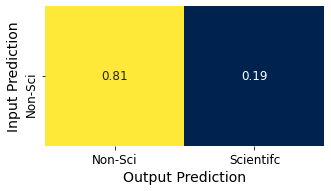


Considering only sentences from: cs_conf
input_roberta_label     0  
output_roberta_label    202
dtype: int64


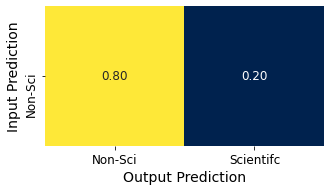


Considering only sentences from: student
input_roberta_label     0  
output_roberta_label    261
dtype: int64


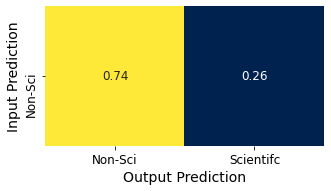


Considering only sentences from: medium
input_roberta_label     0 
output_roberta_label    94
dtype: int64


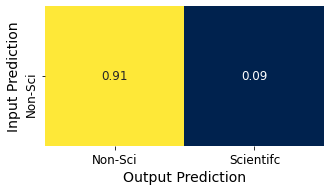



Analysing: T5_p3
Using: roberta
All sentences: 
input_roberta_label     0   
output_roberta_label    1013
dtype: int64


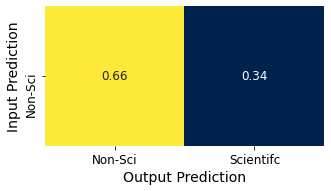


Considering only sentences from: cs_conf
input_roberta_label     0  
output_roberta_label    351
dtype: int64


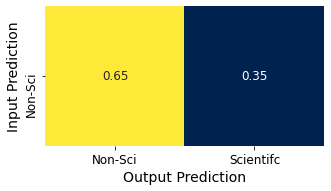


Considering only sentences from: student
input_roberta_label     0  
output_roberta_label    437
dtype: int64


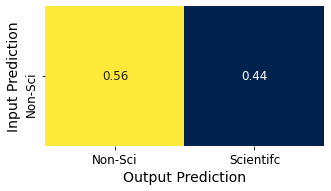


Considering only sentences from: medium
input_roberta_label     0  
output_roberta_label    225
dtype: int64


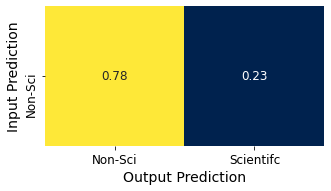



Analysing: GPT2
Using: roberta
All sentences: 
input_roberta_label     0  
output_roberta_label    633
dtype: int64


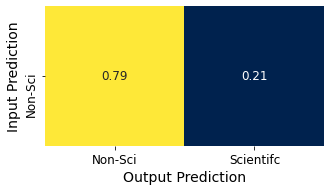


Considering only sentences from: cs_conf
input_roberta_label     0  
output_roberta_label    254
dtype: int64


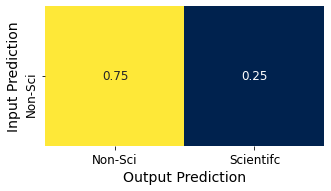


Considering only sentences from: student
input_roberta_label     0  
output_roberta_label    254
dtype: int64


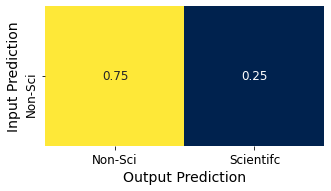


Considering only sentences from: medium
input_roberta_label     0  
output_roberta_label    125
dtype: int64


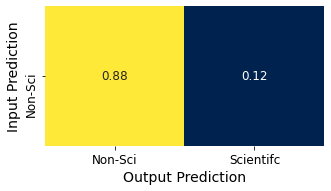

In [ ]:
for key, df in data.items():
  print(f'Analysing: {key}')
  analysis(df, classifier='roberta', display_cm=True, top_only = True)
  print()

## Looking at the change of softmax probabilities regarding scientificity from model input to model output

Considering only sentences from: cs_conf
Considering only sentences from: student
Considering only sentences from: medium


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


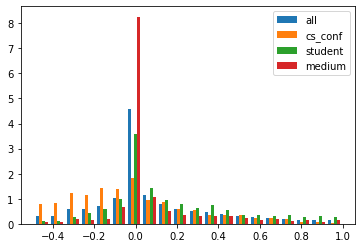


all: mean:0.08, (std: 0.29) 

cs_conf: mean:-0.01, (std: 0.30) 

student: mean:0.17, (std: 0.31) 

medium: mean:0.08, (std: 0.22) 


In [ ]:
prob_diff(df= data_T5_p2)

Considering only sentences from: cs_conf
Considering only sentences from: student
Considering only sentences from: medium


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


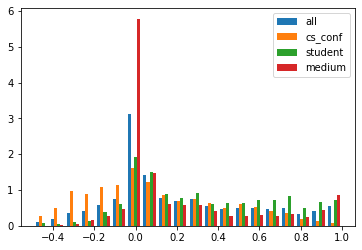


all: mean:0.22, (std: 0.35) 

cs_conf: mean:0.11, (std: 0.33) 

student: mean:0.33, (std: 0.35) 

medium: mean:0.21, (std: 0.33) 


In [ ]:
prob_diff(df= data_T5_p3)

Considering only sentences from: cs_conf
Considering only sentences from: student
Considering only sentences from: medium


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


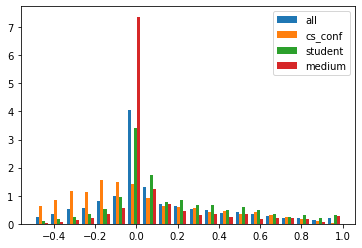


all: mean:0.10, (std: 0.30) 

cs_conf: mean:0.02, (std: 0.32) 

student: mean:0.18, (std: 0.31) 

medium: mean:0.10, (std: 0.25) 


In [ ]:
prob_diff(df= data_GPT2_p3)

**Examples of medium sentences with roughly same prob**

In [ ]:
cond = np.abs(data_T5_p3['output_roberta_prob']-data_T5_p3['input_roberta_prob'])<=0.001
print(len(data_T5_p3[data_T5_p3.source == 'medium'][cond]))
data_T5_p3[data_T5_p3.source == 'medium'][cond].head()

print()

166



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


**Examples of improved sentences**

In [ ]:
cond = ((data_T5_p3['output_roberta_prob']-data_T5_p3['input_roberta_prob']) >=0.8)*((data_T5_p3['output_roberta_prob']-data_T5_p3['input_roberta_prob'])<=0.9)
print(len(data_T5_p3[cond]))
data_T5_p3[cond].head(30)[['input', 'output', 'input_masked', 'output_masked']]

114


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,input,output,input_masked,output_masked
78,"with such a large dataset of what is being said online ready to be processed by a computer program, the possibilities are infinite.",the possibilities are infinite when the available online discourse is such a large dataset ready to be processed by a computer program.,"with such a large <unk> of what is being said online ready to be processed by a <unk> <unk>, the <unk> are infinite.",the possibilities are infinite when the available online discourse is such a large <unk> ready to be processed by a computer <unk>.
256,"meanwhile, data collectors that receive data from sensor nodes, are always ready to receive data from them.","the data collectors, on the other hand, receive data from the sensor nodes, and are always ready to receive data from them.","meanwhile, <unk> collectors that receive <unk> from <unk> <unk>, are always ready to receive <unk> from them.","the <unk> collectors, on the other hand, receive <unk> from the sensor <unk>, and are always ready to receive <unk> from them."
301,"with packet generation, we can perform the zrp as an extension of the model in ref.",we can perform zrp as an extension of the model described in ref.,"with <unk> <unk>, we can perform the zrp as an <unk> of the <unk> in ref.",we can perform zrp as an extension of the <unk> described in ref.
353,"it does not require gradients and hence, it can be used on problems that are not continuous or differentiable.",this design does not require gradients and thus may work for problems that are neither continuous nor diffusive.,"it does not require gradients and <unk>, it can be used on <unk> that are not continuous or differentiable.",this <unk> does not require gradients and thus may work for <unk> that are neither continuous nor diffusive.
514,"when we need more vocabularies, the ones came from the unlabeled training set was then randomly added to the dictionary.",we then randomly added them to lexicons when we needed more vocabularies than the one given in the unlabeled training set.,"when we need more vocabularies, the ones came from the unlabeled <unk> <unk> was then randomly added to the dictionary.",we then randomly added them to lexicons when we needed more vocabularies than the one given in the unlabeled <unk> <unk>.
522,"there are many details about the internals of the scheduler, its dependency analysis, memory management, and other performance enhancements that are not covered here.","there is a lot of detail in the scheduler s internals, ranging from dependency analysis to memory management, and other performance enhancements that is not covered here.","there are many <unk> about the internals of the scheduler, its <unk> <unk>, <unk> management, and other <unk> enhancements that are not covered here.","there is a lot of <unk> in the scheduler s internals, ranging from dependency <unk> to memory management, and other <unk> enhancements that is not covered here."
551,"whatever the answer here we are focusing on the inherent ambiguity, which we will note or record in an appropriate way.","we focus on ambiguity, which we will mark or record in an appropriate way in any answer here.","whatever the <unk> here we are focusing on the inherent ambiguity, which we will note or record in an appropriate <unk>.","we focus on ambiguity, which we will mark or record in an appropriate <unk> in any <unk> here."
702,"from now on, proofs omitted in the main body of the paper can be found in appendix a).",as from now on the proofs omitted in the main body of the paper can be found in appendix a).,"from now on, <unk> omitted in the main body of the <unk> can be found in <unk> a).",as from now on the proofs omitted in the main body of the <unk> can be found in appendix a).
710,we will then discuss in the following sections how to take channel time variation into account.,we discuss in the following sections how to account for channel time variation.,we will then discuss in the following <unk> how to take <unk> <unk

In [ ]:
cond = (data_T5_p3['output_roberta_prob']-data_T5_p3['input_roberta_prob'])>=0.9
print(len(data_T5_p3[cond]))
data_T5_p3[cond].head(20)

150


,Unnamed: 0,source,input,output,input_masked,output_masked,input_roberta_label,input_roberta_prob,input_svm_label,output_roberta_label,output_roberta_prob,output_svm_label,MoverScore,BLEU,F1
51,51,cs_conf,we pick an agent at random (this is the target agent) as well as one of its four neighbors,we assume that a given agent (the target agent) and one of its four neighbors are chosen at random.,we pick an <unk> at <unk> (this is the <unk> <unk>) as well as one of its four <unk>,we assume that a given <unk> (the target <unk>) and one of its four neighbors are chosen at <unk>.,0,0.080962,0,1,0.989140,0,0.640092,0.291537,0.672545
79,79,cs_conf,so we see that forecaster is losing utility because of her local predictive commitments.,this shows that the prediction process loses utility due to its local adversity.,so we see that forecaster is losing <unk> because of her local predictive commitments.,this shows that the <unk> <unk> loses utility due to its local adversity.,0,0.013058,0,1,0.926662,1,0.642642,0.232909,0.699373
88,88,cs_conf,"the focus is mostly on utilizing within-document features, such as term frequencies.","we focus mostly on the use of within-document features, such as term frequencies.","the <unk> is mostly on utilizing within-document <unk>, such as <unk> <unk>.","we focus mostly on the <unk> of within-document <unk>, such as term frequencies.",0,0.030501,1,1,0.979652,0,0.876230,0.503175,0.634109
133,133,cs_conf,the channel state information (csi) is supposed to be known to the receiver but not to the transmitter.,we presume that the receiver but not the transmitter has information about the channel state information (csi).,the <unk> <unk> <unk> (<unk>) is supposed to be known to the <unk> but not to the <unk>.,we presume that the receiver but not the transmitter has <unk> about the <unk> <unk> <unk> (csi).,0,0.087392,1,1,0.998691,0,0.573872,0.367620,0.601707
179,179,cs_conf,"it offers several novelties compared to existing sets, including template based, rather than image based, recognition and a mix of both images and videos.","the new generation of psmrs offers several unique attributes over existing datasets, including template-based vt instead of image-based vt, recognition, and mixing of both image and video features.","it offers several novelties compared to existing <unk>, including template based, rather than <unk> based, recognition and a mix of both <unk>s and <unk>.","the new generation of psmrs offers several unique <unk> over existing <unk>, including template-based vt instead of <unk>-based vt, recognition, and mixing of both <unk> and video <unk>.",0,0.058753,0,1,0.995272,0,0.632779,0.163597,0.720480
275,275,cs_conf,"if we use the global classification error rates, they seem to perform well, however if we use the fitness value or look at fig.","we see that they perform well when using global classification error rates; however, they perform poorly when using fitness values and considering fig.","if we use the global <unk> <unk> <unk>, they seem to perform well, however if we use the fitness <unk> or look at <unk>.","we see that they perform well when using global classification <unk> <unk>; however, they perform poorly when using fitness <unk> and considering fig.",0,0.024529,0,1,0.967883,0,0.658111,0.136580,0.746913
478,478,cs_conf,"hybrid systems modeled by quantum markov chains have already been often encountered in quantum information processing, and the quantum engineering systems developed in the future will most probably be hybrid systems.","hybrid systems as modeled by quantum markov chains have already been commonly encountered in quantum information processing, and there are many applications to quantum engineering that will mainly be hybrid systems.","hybrid <unk> modeled by <unk> <unk> <unk> have already been often encountered in <unk> <unk> <unk>, and the <unk> engineering <unk> developed in the <unk> will most probably be hybrid <unk>.","hybrid <unk> as modeled by quantum markov chains 

In [ ]:
cond = (data_T5_p3['output_roberta_prob']-data_T5_p3['input_roberta_prob'])>=0.8
print(len(data_T5_p3[cond]))
data_T5_p3[cond].sample(20)

264


,Unnamed: 0,source,input,output,input_masked,output_masked,input_roberta_label,input_roberta_prob,input_svm_label,output_roberta_label,output_roberta_prob,output_svm_label,MoverScore,BLEU,F1
1746,1746,student,"also, as delay allowance enters the model the ilp formulation becomes more complicated and more solutions are possible which could yield the wider spread from the mean solution value.","furthermore, if the delay allowance is introduced into the ilp formula, the ilp formulation becomes more complex and would allow fewer solutions, which could lead to a larger difference in the resulting snrs from the averaged solution value.","also, as <unk> <unk> enters the <unk> the <unk> formulation becomes more complicated and more <unk> are possible which could yield the wider spread from the mean <unk> <unk>.","furthermore, if the delay allowance is introduced into the ilp formula, the ilp formulation becomes more complex and would allow fewer <unk>, which could lead to a larger difference in the resulting snrs from the averaged <unk> <unk>.",0,0.025987,0,1,0.976677,0,0.589743,0.146499,0.697521
2761,2761,medium,"for example, it can integrate with google-developed kubernetes and other apache products such as hadoop, cassandra, mesos and hbase.","the new development allows to integrate google kubernetes along with other apache products like hadoop, cassandra, mesos, and hbase.","for <unk>, it can integrate with <unk> kubernetes and other <unk> <unk> such as <unk>, <unk>, <unk> and <unk>.","the new development allows to integrate google kubernetes along with other apache products like hadoop, cassandra, mesos, and hbase.",0,0.018622,0,1,0.965204,0,0.771815,0.266133,0.752363
1971,1971,student,choosing av representation when choosing av representation instead of mi one needs to either summarize all the instances in one example into a representative instance or give all the individual instances the example label.,one needs to choose the av representation instead of mi and either re-rank all the instances in an example by its example identifier or assign each instance a representative instance identifier by its name.,choosing <unk> <unk> when choosing <unk> <unk> instead of <unk> one needs to either summarize all the <unk> in one <unk> into a representative <unk> or give all the individual <unk> the <unk> label.,one needs to choose the av <unk> instead of mi and either re-rank all the <unk> in an <unk> by its <unk> identifier or assign each <unk> a representative <unk> identifier by its name.,0,0.014852,0,1,0.990774,0,0.577024,0.246240,0.653656
522,522,cs_conf,"there are many details about the internals of the scheduler, its dependency analysis, memory management, and other performance enhancements that are not covered here.","there is a lot of detail in the scheduler s internals, ranging from dependency analysis to memory management, and other performance enhancements that is not covered here.","there are many <unk> about the internals of the scheduler, its <unk> <unk>, <unk> management, and other <unk> enhancements that are not covered here.","there is a lot of <unk> in the scheduler s internals, ranging from dependency <unk> to memory management, and other <unk> enhancements that is not covered here.",0,0.188594,0,1,0.990631,0,0.745017,0.313721,0.714443
1799,1799,student,the objective of this research question is to identify the machine learning approach that outperforms the others in terms of accuracy of predicting the health status of an individual.,the goal of this research is to identify the machine learning approach which outperforms others in terms of accuracy for predicting the individual s personal status.,the objective of this <unk> <unk> is to identify the machine learning <unk> that outperforms the others in terms of <unk> of predicting the <unk> status of an individual.,the goal of this <unk> is to identify the <unk> <unk> <unk> which outperforms others in terms of <unk> for predicting the individual s personal status.,0,0.0

**Mean scientificity probability of model input**

In [ ]:
for key in set(df.source.to_list()):
  print(key)
  print(data_T5_p3[data_T5_p3.source == key]['input_roberta_prob'].mean())

  

cs_conf
0.2784894318450242
student
0.12369681816286175
medium
0.04699342163145775


**Mean scientificity probability of model output**

In [ ]:
for key in set(df.source.to_list()):
  print(key)
  print(data_T5_p3[data_T5_p3.source == key]['output_roberta_prob'].mean())

cs_conf
0.385133581898408
student
0.45843934749794424
medium
0.2551752262285445


# Semantic Evaluation

In this section we illustrate Moverscore achieved by our models, aswell as the diversity (inv.BLEU) to put Moverscore in perspective.

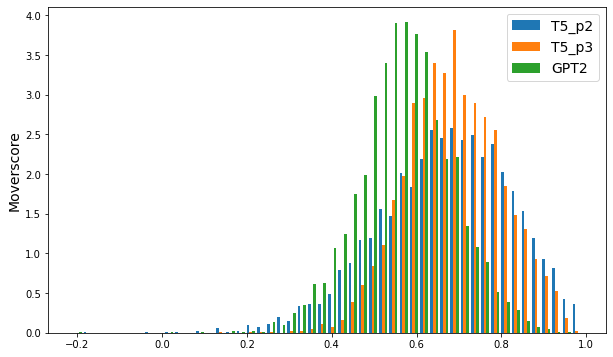

Data: T5_p2 | Mean MS: 0.67, (STD: 0.16)
Data: T5_p3 | Mean MS: 0.69, (STD: 0.11)
Data: GPT2 | Mean MS: 0.57, (STD: 0.11)


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,6))

ax.hist([x['MoverScore'] for _,x in data.items()], label = [key for key, _ in data.items()], density = True, bins = 50 )
ax.legend(fontsize = 14)
ax.set_ylabel('Moverscore', fontsize = 14)
plt.show()

for key, x in data.items():
  x = x['MoverScore']
  print(f'Data: {key} | Mean MS: {np.mean(x):.2f}, (STD: {np.std(x):.2f})')

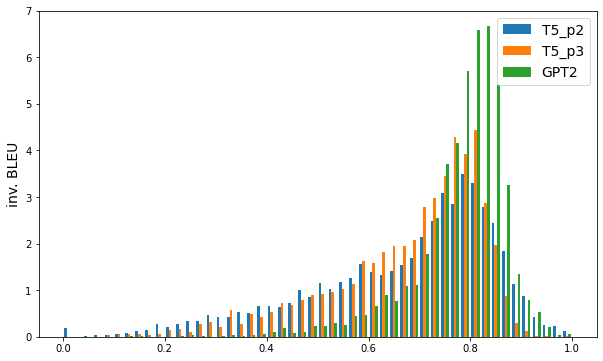

Data: T5_p2 | Mean BLEU: 0.67, (STD: 0.18)
Data: T5_p3 | Mean BLEU: 0.68, (STD: 0.15)
Data: GPT2 | Mean BLEU: 0.78, (STD: 0.09)


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,6))

ax.hist([1-x['BLEU'] for _,x in data.items()], label = [key for key, _ in data.items()], density = True, bins = 50 )
ax.legend(fontsize = 14)
ax.set_ylabel('inv. BLEU', fontsize = 14)
plt.show()

for key, x in data.items():
  x = 1-x['BLEU']
  print(f'Data: {key} | Mean BLEU: {np.mean(x):.2f}, (STD: {np.std(x):.2f})')

In [ ]:
def F1(x,y):
  if (x==None) or (y==None):
    return None
  else:
    return 2*(x*y)/(x+y)   

for _, x in data.items():
  x['F1'] = [F1(MS,1-B) for MS,B in zip(x['MoverScore'],x['BLEU'])]

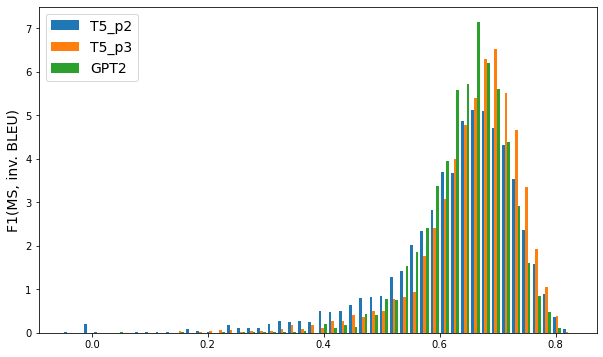

Data: T5_p2 | Mean F1: 0.63, (STD: 0.11)
Data: T5_p3 | Mean F1: 0.66, (STD: 0.08)
Data: GPT2 | Mean F1: 0.65, (STD: 0.07)


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,6))

ax.hist([x['F1'] for _,x in data.items()], label = [key for key, _ in data.items()], density = True, bins = 50 )
ax.legend(fontsize = 14)
ax.set_ylabel('F1(MS, inv. BLEU)', fontsize = 14)
plt.show()

for key, x in data.items():
  x = x['F1']
  print(f'Data: {key} | Mean F1: {np.mean(x):.2f}, (STD: {np.std(x):.2f})')

# Additional RoBERTa Experiment

Lastly, we perform an experiment on a new test set, in which input sentences are chosen indepedently of their RoBERTa label

In [ ]:
data2 = pd.read_excel(data_path+'final_eval2_corrected.xlsx')
data2.head()

,Unnamed: 0,Unnamed: 0.1.1,sent,true_label,pred_label,prob0,prob1,prob_max,len,sent_masked,source,paraphrase,praphrase_masked,para_label,para_prob0,para_prob1,para_prob_max,para_len
0,0,73110,this allows us to use similarity metrics on past actions to find non-friends who are as similar in preferences to a user as her actual friends.,1,0,0.563415,0.436585,0.563415,29,this allows us to use <unk> <unk> on past <unk> to find non-friends who are as similar in <unk> to a <unk> as her actual friends.,cs_conf,this allows us to harness past behaviour similarity to learn non-friends whose preferences are as similar as those of the actual user.,this allows us to harness past behaviour similarity to learn non-friends whose preferences are as similar as those of the actual <unk>.,1,0.290120,0.709880,0.709880,29
1,1,3007,that is why we defined the conditional probability with respect to a specific delay.,1,0,0.576455,0.423545,0.576455,15,that is why we defined the conditional <unk> with <unk> to a specific <unk>.,cs_conf,we derived such conditional probability with respect to a given delay.,we derived such conditional <unk> with respect to a given <unk>.,1,0.188913,0.811087,0.811087,15
2,2,111845,this section discusses the datasets used in the experiments and shows a synthetic evaluation of the method as well as experiments based on real data.,1,0,0.677521,0.322479,0.677521,26,this <unk> discusses the <unk> used in the <unk> and shows a synthetic <unk> of the <unk> as well as <unk> based on real <unk>.,cs_conf,"in this section, we discuss the datasets used for the experiments and present the synthetic evaluation of the method along with experiments on real data.","in this <unk>, we discuss the <unk> used for the <unk> and present the synthetic evaluation of the <unk> along with <unk> on real <unk>.",1,0.150792,0.849208,0.849208,26
3,3,129133,the ground truth is indicated with a solid line while the nodes along the predicted are shown as dots.,1,0,0.542001,0.457999,0.542001,20,the <unk> truth is indicated with a solid <unk> while the <unk> along the predicted are shown as dots.,cs_conf,the ground truth points are indicated by solid lines and the edgepoints along the expected paths are highlighted by the dot.,the ground truth <unk> are indicated by solid <unk> and the edge<unk> along the expected <unk> are highlighted by the dot.,0,0.735963,0.264038,0.735963,20
4,4,129058,"map building with robots is interesting because there are often no exact ground truths, only location estimates.",1,0,0.851524,0.148476,0.851524,19,"<unk> building with <unk> is interesting because there are often no exact <unk> truths, only <unk> <unk>.",cs_conf,"robot mappings are interesting in that, often, the ground truth is not exactly known, only location estimates are used.","robot mappings are interesting in that, often, the ground truth is not exactly known, only location estimates are used.",0,0.918799,0.081201,0.918799,19


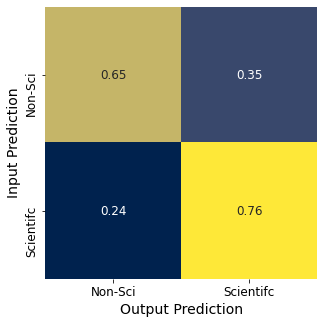

In [ ]:
cm = confusion_matrix(data2['pred_label'], data2['para_label'], normalize = 'true')
show_confusion_matrix(cm, top_only=False)


cs_conf


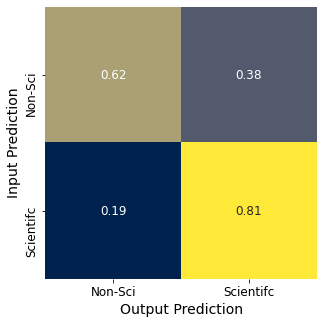

student


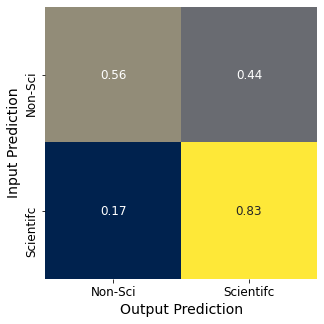

medium


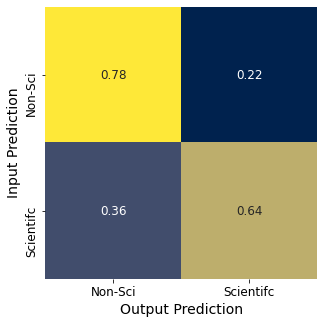

In [ ]:
for key in set(data2.source.to_list()):
  print(key)
  df = data2[data2.source == key]
  cm = confusion_matrix(df['pred_label'], df['para_label'], normalize = 'true')
  show_confusion_matrix(cm, top_only=False) 